# Hermite Spline Interpolation
## This notebook was adapted from code first written by Nils Wandel

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

### In this notebook, we will derive hermite kernel functions for interpolation.

In [7]:
def monomial_derivative(order, x, derivative = 0):
    """
    Returns the value of the derivative of a monomial at a point x.
    If the derivative = 0, returns the value of the monomial itself at x.
    """
    if derivative > order:
        return 0
    else:
        resulting_order = order - derivative
        return np.math.factorial(order) / np.math.factorial(resulting_order) * x** resulting_order

In [8]:
def get_monomial_values(highest_order, x, derivative):
    """
    Returns the values of the nth derivative of monomials of order i, where i is an integer ranging
    from 0 to highest_order (inclusive).
    
    Values are returned in a numpy array in order of increasing order.
    When derivative = 0, this corresponds to the values of the monomials themselves.
    """
    values = np.zeros(highest_order + 1)
    for order in range(len(values)):
        values[order] = monomial_derivative(order, x, derivative)
    return values

## How to derive hermite spline kernels

### For hermite interpolation, we seek coefficients of polynomials defined by their values at domain endpoints, and by the values of derivatives at the endpoints.

In [9]:
# the first two rows represent the values of the functions and their derivatives at the x = 0 support point
# the last two rows represent the values of the functiuons and their derivatives at the endpoints (usually x = +-1)
# the i'th column represents these values for the monomial of order i

def create_monomial_val_matrix(num_monomials, endpoints):
    
    if num_monomials % 2 != 0:
        raise Exception("num_monomials must be even as the functions are evaluated at two endpoints")
        
    # sort endpoints so that they are in order of increasing absolute value
    # this is needed since we compute coefficients to the right, and to the left, of 0.
    # wish to be able to reuse a single function
    endpoints.sort(key=abs)

    shape = (num_monomials, num_monomials)

    monomial_vals = np.empty(shape)
    
    def populate_monomial_vals_matrix(support_point_index):
        num_derivative_evals = num_monomials // 2
        for i in range(num_derivative_evals):
            monomial_vals[i + support_point_index * num_derivative_evals,:] = get_monomial_values(num_monomials - 1, 
                                                                                                  endpoints[support_point_index], 
                                                                                                  i)

    
    populate_monomial_vals_matrix(support_point_index=0)
    populate_monomial_vals_matrix(support_point_index=1)
    
    return monomial_vals

MM = create_monomial_val_matrix(6, [1, 0]); MM

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 0.,  0.,  2.,  6., 12., 20.]])

In [10]:
# Now, let's assume that we wish determine 
# coefficients of a polynomial f 
# having f(0)=f(1)=f'(1) = 0, and f'(0) = 1

# We use a vector to represent our desired values of the function and its derivative
# at each of these points -> v = [f(0), f'(0), f(1), f'(1)]

v = np.array([0, 1, 0, 0])
MM = create_monomial_val_matrix(len(v), [0,1])
s = np.linalg.solve(MM, v); s

array([ 0.,  1., -2.,  1.])

In [11]:
# We can repeat this process for any sort of v and endpoints!
v = np.array([1, 1, 0, 0])
MM = create_monomial_val_matrix(len(v), [0,2])
s = np.linalg.solve(MM, v); s

array([ 1.  ,  1.  , -1.75,  0.5 ])

In [12]:
# We can repeat this process for any sort of v and endpoints!
v = np.array([1, 0, 0, 0])
MM = create_monomial_val_matrix(len(v), [0,1])
s = np.linalg.solve(MM, v); s

array([ 1.,  0., -3.,  2.])

In [13]:
# Let's write a function that does this for us
def determine_coefficients(v, endpoints):
    '''
    v: a vector containing the values of the summed function and its derivatives at the support points.
        The first half of the vector contains the values and derivatives of the summed function at x = endpoints[0]
        The second half of the vector contains the values and derivatives of the summed function at x = endpoints[1]
        For instance, if len(v) == 4, then v = [f(endpoints[0]), f'(endpoints[0]), f(endpoints[1]), f'(endpoints[1])]
    endpoints: An array of length 2 containing the endpoint values (the domain of the function ranges from 0 
            to +-endpoint[1] usually)
    returns: a numpy array containing the coefficients of each monomial degree that is used to construct
            the polynomial satisfying the value and derivative constraints at support points.
            For instance, array([ 5.,  0.,  3., -2.]) corresponds to f(x) = 5 + 3x^2 - 2x^3
    '''
    MM = create_monomial_val_matrix(len(v), endpoints)
    return np.linalg.solve(MM, v)

determine_coefficients(v, [0,1])

array([ 1.,  0., -3.,  2.])

In [14]:
# also works if we do [-1, 0]!
v = np.array([0, 0, 1, 0])
determine_coefficients(v, [-1,0])

array([0., 0., 3., 2.])

## Let's compute and plot a polynomial constructed from the Hermite kernels!

In [15]:
def polynomial(weights, x):
    y = np.zeros_like(x)
    for order in range(len(weights)):
        y += weights[order] * monomial_derivative(order, x, 0)
    return y

def kernel(v, xvals):

    left_weights = determine_coefficients(v, [-1,0])
    right_weights = determine_coefficients(v, [0,1])
    
    left_polynomial = polynomial(left_weights, xvals)
    right_polynomial = polynomial(right_weights, xvals)
    
    return np.heaviside(-xvals, 0.5) * left_polynomial + np.heaviside(xvals, 0.5) * right_polynomial   

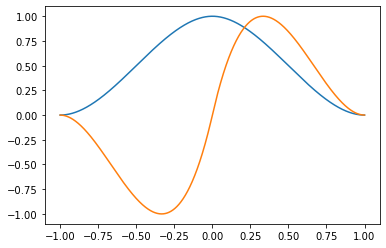

In [16]:
vs = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0]])
xvals = np.arange(-1, 1, 0.0001)
for v in vs:
    y = kernel(v,xvals)
    y /= np.max(np.abs(y)) # "normalize" curves to fit into [-1, 1]
    plt.plot(xvals, y)
plt.show()

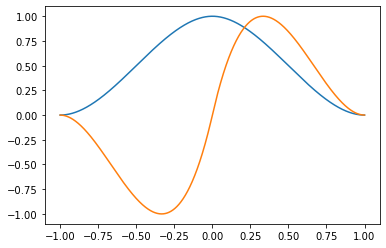

In [17]:
# Lets turn this into a function which returns the kernels

def kernels(highest_order, xvals):
    hermite_values = np.eye(highest_order + 1)
    # for hermite, we only ever alter the value / derivative at 0
    # all other derivatives and values are 0 (i.e. at 1 and -1)
    
    num_conditions = (highest_order + 1) // 2
    hermite_values = hermite_values[:num_conditions]

    yvals = np.empty((num_conditions, xvals.shape[0]))
    for index, v in enumerate(hermite_values):
        y = kernel(v,xvals)
        y /= np.max(np.abs(y)) # "normalize" curves to fit into [-1, 1]
        yvals[index,:] = y
    return yvals

xvals = np.arange(-1, 1, 0.0001)
yvals = kernels(3, xvals)
for yval in yvals:
    plt.plot(xvals, yval)
    
plt.show()


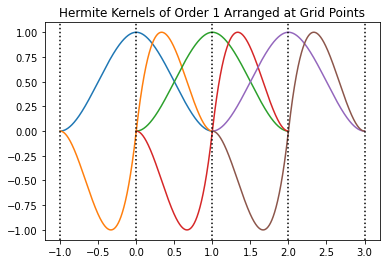

In [18]:
# now let's plot them side by side

def plot_kernels_side_by_side(yvals, number_of_times, domain):
    for n in range(number_of_times):
        for yval in yvals:
            plt.plot(domain + n, yval)
    plt.title("Hermite Kernels of Order 1 Arranged at Grid Points")
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axvline(x=1, color='black', linestyle='dotted')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axvline(x=-1, color='black', linestyle='dotted')
    plt.axvline(x=3, color='black', linestyle='dotted')
    plt.show()


xvals = np.arange(-1, 1, 0.0001)
# xvals = np.arange(-1, 1.000001, 2/1000)
yvals = kernels(3, xvals)

plot_kernels_side_by_side(yvals, 3, xvals)

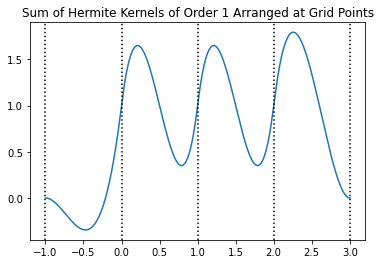

In [19]:
# now, let's rewrite the plotting function so that it adds the kernels
def plot_kernel_sums_side_by_side(yvals, number_of_times, domain):
    big_domain_size = domain.shape[0] + int(domain.shape[0] * (number_of_times - 1)/2)
    resulting_y = np.zeros((big_domain_size))
    resulting_x = np.zeros((big_domain_size))
    each_cell_sum = np.sum(yvals, axis=0)
    resulting_x = np.arange(-1, number_of_times, 0.0001)
    for n in range(number_of_times):
        resulting_y[int(domain.shape[0] * (n)/2) : int(domain.shape[0] * (n+2)/2)] += np.sum(yvals, axis = 0)
    plt.plot(resulting_x, resulting_y)
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axvline(x=1, color='black', linestyle='dotted')
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axvline(x=-1, color='black', linestyle='dotted')
    plt.axvline(x=3, color='black', linestyle='dotted')
    plt.title("Sum of Hermite Kernels of Order 1 Arranged at Grid Points")
    plt.show()
    return resulting_y
resulting_y = plot_kernel_sums_side_by_side(yvals, 3, xvals)

## Now we see how to construct polynomials using Hermite Kernels. We can do this better using pytorch and convolutions

In [20]:
import torch.nn.functional as F
import torch

In [21]:
kernel_weights = torch.ones((1,3), dtype=torch.float64); kernel_weights # 1 sequence of weights across 3 grid points

tensor([[1., 1., 1.]], dtype=torch.float64)

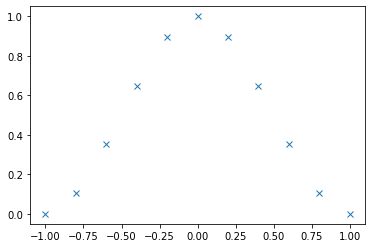

In [22]:
# Now let's grab one of our kernels, generate a plot on 11 total points between -1 and 1
xvals = np.arange(-1, 1.1, 2/10)
yvals = kernels(3, xvals)
plt.plot(xvals, yvals[0], 'x')

In [23]:
# Now, lets turn these kernel values into a tensor
kernel_values = torch.from_numpy(yvals[0].copy()); kernel_values

tensor([0.0000, 0.1040, 0.3520, 0.6480, 0.8960, 1.0000, 0.8960, 0.6480, 0.3520,
        0.1040, 0.0000], dtype=torch.float64)

In [24]:
# Now, let's convolve
stride = kernel_values.shape[0] // 2

In [25]:
answer = F.conv_transpose1d(kernel_weights.unsqueeze(0), kernel_values.unsqueeze(0).unsqueeze(0), 
         padding = 0, stride = stride)

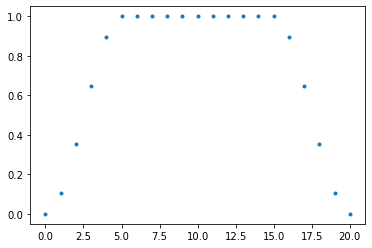

In [26]:
plt.plot(answer[0][0], '.')

In [27]:
# Now, let's try convolving with two sets of weights
kernel_weights = torch.ones((2,5), dtype=torch.float64); kernel_weights # 1 sequence of weights across 5 points

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], dtype=torch.float64)

In [29]:
kernel_values = torch.from_numpy(yvals.copy()).reshape(2,1,-1); kernel_values

tensor([[[ 0.0000e+00,  1.0400e-01,  3.5200e-01,  6.4800e-01,  8.9600e-01,
           1.0000e+00,  8.9600e-01,  6.4800e-01,  3.5200e-01,  1.0400e-01,
           0.0000e+00]],

        [[ 0.0000e+00, -2.2222e-01, -6.6667e-01, -1.0000e+00, -8.8889e-01,
          -1.5420e-15,  8.8889e-01,  1.0000e+00,  6.6667e-01,  2.2222e-01,
           0.0000e+00]]], dtype=torch.float64)

In [30]:
answer = F.conv_transpose1d(kernel_weights.unsqueeze(0), kernel_values, 
         padding = 0, stride = stride, groups=1); answer

tensor([[[ 0.0000, -0.1182, -0.3147, -0.3520,  0.0071,  1.0000,  1.6667,
           1.3333,  0.6667,  0.3333,  1.0000,  1.6667,  1.3333,  0.6667,
           0.3333,  1.0000,  1.6667,  1.3333,  0.6667,  0.3333,  1.0000,
           1.6667,  1.3333,  0.6667,  0.3333,  1.0000,  1.7849,  1.6480,
           1.0187,  0.3262,  0.0000]]], dtype=torch.float64)

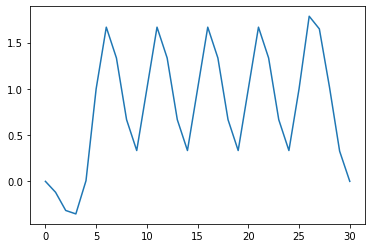

In [31]:
plt.plot(answer[0][0])

## Now we know we can sum up arbitrary hermite kernels across a grid. Let's write up our work in functions, and add many more values to our kernels so that the resulting function looks much smoother.

In [32]:
def interpolate_wave(coefficients, kernels):
    '''
    Interpolates a wave function by convolving the coefficients with the hermite spline kernels
    coefficients: Tensor of size (minibatch, num_kernel_types, width)
    kernels: Tensor of size (num_kernel_types, output_waves (usually 1), width)
    '''
    stride = kernels.shape[2] // 2
    return F.conv_transpose1d(coefficients, kernels, 
         padding = 0, stride = stride, groups=1)

def generate_kernels(num_points, order):
    if num_points % 2 == 0:
        raise Exception("num_points must be odd!")
    xvals = np.linspace(-1, 1, num_points)
    numpy_kernels = kernels(order, xvals) # array with shape (num_kernels, num_points)
    return torch.from_numpy(numpy_kernels).unsqueeze(1) # insert new rank into tensor to correspond to convolution API

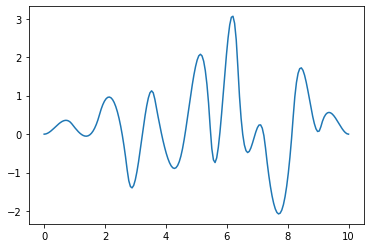

In [34]:
num_non_boundary_grid_points = 10

sample_coefficients = torch.randn(1,2, num_non_boundary_grid_points, dtype=torch.float64)

num_kernel_support_points = 35 # must be odd

sample_kernels = generate_kernels(num_kernel_support_points, 3)
wave = interpolate_wave(sample_coefficients, sample_kernels)

xvals = np.linspace(0, num_non_boundary_grid_points, 1 + (num_non_boundary_grid_points + 1) * (num_kernel_support_points // 2))
plt.plot(xvals, wave[0][0])